In [182]:
# https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
# https://colab.research.google.com/drive/1-SVO8G2DoXA0f-629I2zgCOjAo1FHH-B#scrollTo=D96WZP8cVOFL
# https://app.jedha.co/course/recurrent-neural-networks-ft/code-recurrent-neural-network-ft
# https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
from num2words import num2words
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import re
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split

from sklearn.metrics import( accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, 
                             f1_score, mean_squared_error, r2_score, RocCurveDisplay )

import spacy
import en_core_web_sm


# Tfidf transformer 
from sklearn.feature_extraction.text import TfidfVectorizer

#https://www.nltk.org/howto/stem.html
from nltk.stem.porter import *


In [183]:
dataset = pd.read_csv('src/dataset_encoded.csv')
dataset['text_encoded'] = [eval(i) for i in dataset['text_encoded']]

## Keras preprocessing

In [184]:
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset['text_encoded'], padding="post")

In [185]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(reviews_pad,dataset.target, test_size=0.3)

## Create batch

In [186]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

train_batch = train.shuffle(train.cardinality()).batch(64)
val_batch = val.shuffle(val.cardinality()).batch(64)

In [187]:
review = []
 # Some batch
for review, star in train_batch.take(1):
    # print(review, star)
    review = review

## Tokenizer

In [188]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(dataset.text)
dataset["text_encoded"] = tokenizer.texts_to_sequences(dataset.text)


In [189]:
dataset

,keyword,text,target,text_encoded
0,ablaz,ablaz bbcmtd wholesal market ablaz,1,"[213, 1, 1, 310, 213]"
1,ablaz,ablaz tri bring heavi metal rt,0,"[213, 220, 453, 697, 962, 90]"
2,ablaz,ablaz africanbaz break newsnigeria flag set...,1,"[213, 1, 270, 1, 527, 221, 213, 910]"
3,ablaz,ablaz cri set ablaz,0,"[213, 624, 221, 213]"
4,ablaz,ablaz plu look sky night ablaz,0,"[213, 1, 48, 724, 285, 213]"
...,...,...,...,...
7547,wreck,wreck jtruff23 cameronhack wreck,0,"[30, 1, 1, 30]"
7548,wreck,wreck day work ve pretti wreck hahaha shout...,0,"[30, 56, 98, 119, 588, 30, 1, 1, 58]"
7549,wreck,wreck fx forex trade cramer iger word wreck...,0,"[30, 1, 1, 1, 1, 1, 345, 30, 853, 364]"
7550,wreck,wreck enginesh great atmospher british lion...,0,"[30, 1, 233, 1, 756, 1, 1, 314, 383, 30]"


## Modeling

In [190]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=(review.shape[1],),name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="linear")
])

In [191]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 8)             8008      
                                                                 
 global_average_pooling1d_9   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 16)                144       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 8,169
Trainable params: 8,169
Non-trainable params: 0
_________________________________________________________________


## keras model

In [192]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

## Training test

In [193]:
history = model.fit(train_batch, 
                    epochs=20, 
                    validation_data=val_batch)

Epoch 1/20
83/83 [==============================] - 1s 5ms/step - loss: 0.2908 - mean_absolute_error: 0.4676 - val_loss: 0.2417 - val_mean_absolute_error: 0.4865
Epoch 2/20
83/83 [==============================] - 0s 2ms/step - loss: 0.2322 - mean_absolute_error: 0.4757 - val_loss: 0.2208 - val_mean_absolute_error: 0.4614
Epoch 3/20
83/83 [==============================] - 0s 2ms/step - loss: 0.2024 - mean_absolute_error: 0.4374 - val_loss: 0.1806 - val_mean_absolute_error: 0.4010
Epoch 4/20
83/83 [==============================] - 0s 2ms/step - loss: 0.1619 - mean_absolute_error: 0.3629 - val_loss: 0.1519 - val_mean_absolute_error: 0.3312
Epoch 5/20
83/83 [==============================] - 0s 3ms/step - loss: 0.1431 - mean_absolute_error: 0.3148 - val_loss: 0.1482 - val_mean_absolute_error: 0.3204
Epoch 6/20
83/83 [==============================] - 0s 2ms/step - loss: 0.1364 - mean_absolute_error: 0.2987 - val_loss: 0.1447 - val_mean_absolute_error: 0.2988
Epoch 7/20
83/83 [==========

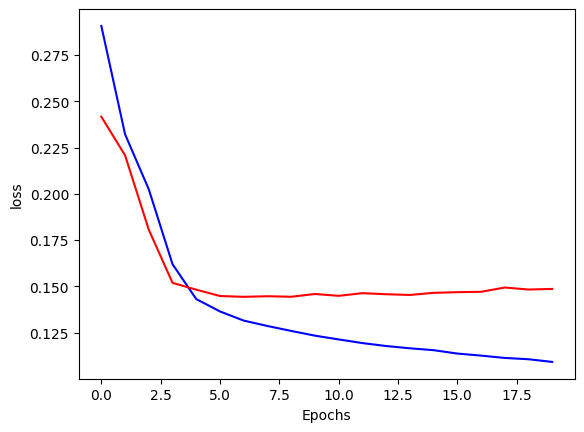

In [194]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

## Visualization of accuracy training 

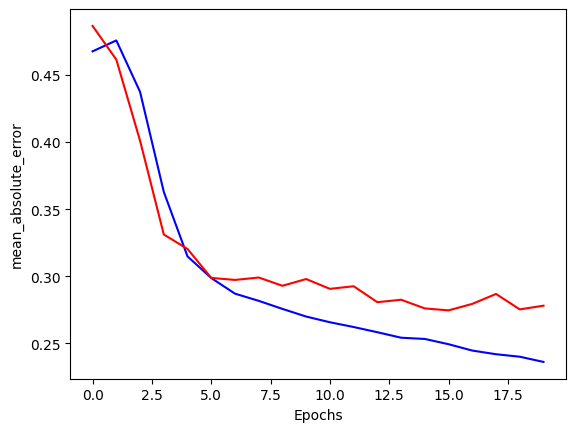

In [195]:
plt.plot(history.history["mean_absolute_error"], color="b")
plt.plot(history.history["val_mean_absolute_error"], color="r")
plt.ylabel("mean_absolute_error")
plt.xlabel("Epochs")
plt.show()

## Training

In [196]:
model.fit(train_batch, epochs=4, validation_data=val_batch)

Epoch 1/4
83/83 [==============================] - 0s 3ms/step - loss: 0.1080 - mean_absolute_error: 0.2337 - val_loss: 0.1478 - val_mean_absolute_error: 0.2739
Epoch 2/4
83/83 [==============================] - 0s 3ms/step - loss: 0.1071 - mean_absolute_error: 0.2318 - val_loss: 0.1489 - val_mean_absolute_error: 0.2703
Epoch 3/4
83/83 [==============================] - 0s 3ms/step - loss: 0.1066 - mean_absolute_error: 0.2291 - val_loss: 0.1494 - val_mean_absolute_error: 0.2642
Epoch 4/4
83/83 [==============================] - 0s 3ms/step - loss: 0.1050 - mean_absolute_error: 0.2256 - val_loss: 0.1516 - val_mean_absolute_error: 0.2740


## Predictions

In [197]:
Y_train_pred = model.predict(xtrain) # Predictions on training set
Y_val_pred = model.predict(xval) # Prédictions on test set 

Y_train_pred = np.reshape(np.around(Y_train_pred).astype(int), len(Y_train_pred) )
Y_val_pred = np.reshape(np.around(Y_val_pred).astype(int), len(Y_val_pred) )

71/71 [==============================] - 0s 1ms/step


## Performances evaluation

In [198]:
print("Accuracy on training set : ", accuracy_score(ytrain, Y_train_pred))
print("Accuracy on test set : ", accuracy_score(yval, Y_val_pred))

Accuracy on training set :  0.8609534619750284
Accuracy on test set :  0.7978817299205648
